# Bussiness Case -:

## Forecasting Inventory model to achieve JIT standards

In [1]:
import os
import mysql.connector
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

In [2]:
## making the connections to the database server

connection = mysql.connector.connect(host = '18.136.157.135',
                                    user = 'dm_usdata_sql',
                                    password = '37z<49REb&mKnl4AV!vJ')

In [3]:
## Checking the number of database available on server

cursor = connection.cursor()
cursor.execute('show databases')
for i in cursor:
    print(i)

('information_schema',)
('project_service_data',)


In [4]:
## connecting the database
connection=mysql.connector.connect(host = '18.136.157.135',
                                   user = 'dm_usdata_sql',
                                   password = '37z<49REb&mKnl4AV!vJ',
                                   database='project_service_data')

In [5]:
db_tables=pd.read_sql_query('show tables',connection)
print(db_tables)

  Tables_in_project_service_data
0                   service_data


In [6]:
query = "select * from service_data"
data = pd.read_sql(query,connection)
print(data.shape)
data

(28482, 7)


,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
0,30-05-17,30-05-17,shivXXXXXXXXXX,KA03MFXXXX,BAJAJ AVENGER STREET 220,50000,ENGINE OIL
1,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,ENGINE OIL
2,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,POLISH
3,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,CONSUMABLES
4,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,COOLANT OIL
...,...,...,...,...,...,...,...
28477,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,SPROCKET RUBBER
28478,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,CLUTCH CABLE
28479,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,OIL FILTER
28480,06-01-19,06-01-19,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805,DISC OIL


### Assumption -:

1. We are not going to forecast the model for each Bussiness partner, Instead we are going to aggregate the demand of all the Bussiness partner

## Basic Checks

In [7]:
data.head()

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
0,30-05-17,30-05-17,shivXXXXXXXXXX,KA03MFXXXX,BAJAJ AVENGER STREET 220,50000,ENGINE OIL
1,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,ENGINE OIL
2,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,POLISH
3,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,CONSUMABLES
4,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,COOLANT OIL


In [8]:
data.shape

(28482, 7)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28482 entries, 0 to 28481
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   invoice_date           28482 non-null  object
 1   job_card_date          28482 non-null  object
 2   business_partner_name  28482 non-null  object
 3   vehicle_no             28482 non-null  object
 4   vehicle_model          28482 non-null  object
 5   current_km_reading     28482 non-null  object
 6   invoice_line_text      28476 non-null  object
dtypes: object(7)
memory usage: 1.5+ MB


In [10]:
data.describe()

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
count,28482,28482,28482,28482,28482,28482,28476
unique,555,553,1010,846,28,3474,503
top,01-12-18,01-12-18,venkXXXXXXXXXX,KA53EVXXXX,BAJAJ PULSAR 150,0,ENGINE OIL
freq,179,179,424,1313,8633,842,3802


## Data Cleaning

In [11]:
## Finding the null values

data.isnull().sum()

invoice_date             0
job_card_date            0
business_partner_name    0
vehicle_no               0
vehicle_model            0
current_km_reading       0
invoice_line_text        6
dtype: int64

In [12]:
## % of missing data

a = (data['invoice_line_text'].isnull().sum()/data.shape[0])*100

print('Percentage of Missing data is:',a)

Percentage of Missing data is: 0.02106593638087213


In [13]:
## As the % of missing data is 0.02%, we are going to drop those columns

data.dropna(inplace=True)

In [14]:
data.shape

(28476, 7)

In [15]:
data.columns

Index(['invoice_date', 'job_card_date', 'business_partner_name', 'vehicle_no',
       'vehicle_model', 'current_km_reading', 'invoice_line_text'],
      dtype='object')

### Note: 
'business_partner_name' & 'vehicle_no' columns does'nt seems to affect the forecasting, 
therefore these columns will be dropped

In [16]:
data.drop(['business_partner_name', 'vehicle_no'], axis=1, inplace=True)

### Observations -:

* 'invoice_line_text', this column contains both the final bill charged to end user.
* This column contains both service and spare part charges.
* We have to forecast the demand for Spare Part.
* Therefore, we have to remove all the rows which charges for service.

### Observations -:
('invoice_line_text' is observed and following Assumptions are made)

* 'ONE WAY CLUTCH BUSH KIT' should be used in place of 'SERVICE AND ONE WAY CLUTCH BUSH KIT''
* 'MAGNET COIL AND PICKUP COIL' split this row into 2 rows
* Delete all rows with 'STICKER' except 'NUMBER PLATE WITH STICKERS', replace that with removing sticker
* Delete all rows with 'LABOUR' except 'VISIOR WITH LABOUR', replace that with 'VISIOR'
* Delete all rows with 'overhual' as it is not a item from manufacturer
* Delete all lines with 'CHARGE'
* Delete all lines with 'INSURANCE', 'PAYMENT', 'REGISTER*', 'ADJUSTMENT', 'WELDING', 'REMOVAL', 'THREADING', 'CLEANING', 
* Delete all lines with 'FEES', 'REBORE', 'PUNCHER', 'EX SHOW ROOM', 'DENT', 'RC CARD', 'TAX', 'ENGINE WORK', 'PETROL',
* Delete all lines with 'SERVICE', 'CHECK*'

In [17]:
inventory = data['invoice_line_text'].value_counts()
i = 0
for item, count in inventory.iteritems():
    if item.upper().find('OVERHUAL') != -1:
        i += 1
        print(i, item, count)
    if item.upper().find('OVERHAUL') != -1:
        i += 1
        print(i, item, count)

1 CHAIN OVERHAUL 284
2 CLUTCH OVERHUAL 163
3 DISC OVERHUAL 79
4 FORK OVERHUAL 72
5 TIMMING CHAIN OVERHUAL 4
6 MAGNET OVERHUAL 2
7 FUEL GUAGE OVERHUAL 1
8 COIL OVERHUAL 1
9 ENGINE OVERHUAL 1
10 CONE SET OVERHUAL 1
11 RADIATOR OVERHUAL 1


In [18]:
labels_to_delete = ['CHARGE', 'INSURANCE', 'PAYMENT', 'REGISTER*', 'ADJUSTMENT', 'WELDING', 
                    'REMOVAL', 'THREADING', 'CLEANING', 'FEES', 'REBORE', 'PUNCHER', 'EX SHOW ROOM', 
                    'DENT', 'RC CARD', 'TAX', 'ENGINE WORK', 'SERVICE', 'CHECK']

In [19]:
for index, text in data['invoice_line_text'].iteritems():
    if text == 'SERVICE AND ONE WAY CLUTCH BUSH KIT':
        print('Changed the text from "SERVICE AND ONE WAY CLUTCH BUSH KIT" to "SERVICE AND ONE WAY CLUTCH BUSH KIT"')
        data.loc[index, 'invoice_line_text'] = 'ONE WAY CLUTCH BUSH KIT'
    #
    if text == 'NUMBER PLATE WITH STICKER':
        print('Changed the text from "NUMBER PLATE WITH STICKER" to "NUMBER PLATE"')
        data.loc[index, 'invoice_line_text'] = 'NUMBER PLATE'
        
    if text == 'VISIOR WITH LABOUR':
        print('Changed the text from "VISIOR WITH LABOUR" to "VISIOR"')
        data.loc[index, 'invoice_line_text'] = 'VISIOR'
        
    if text.strip() == 'PETROL':
        print('Deleting line that has PETROL only')
        data.drop(index=index, inplace=True)
        
    if text.upper().find('OVERHUAL') != -1:
        print('Deleting line with text : ', text)
        data.drop(index=index, inplace=True)
        
    if item.upper().find('OVERHAUL') != -1:  #Minor spelling change in data
        i += 1
        print(i, item, count)
        
    for del_str in labels_to_delete:
        if text.upper().find(del_str) != -1:
            print('Deleting line with text : ', text)
            data.drop(index=index, inplace=True)

Deleting line with text :  GENERAL SERVICE
Deleting line with text :  BRAKE ADJUSTMENT
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  BRAKE ADJUSTMENT
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  TANK CLEANING
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CARBURETOR CLEANING
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  DISC OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  BRAKE ADJUSTMENT
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  BRAKE ADJUSTMENT
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  BRAKE ADJUSTMENT
Deleting line with text :  T

Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  FORK OVERHUAL
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text : 

Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  COIL CHECK
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text 

Deleting line with text :  TANK CLEANING
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting l

Deleting line with text :  REGISTER FEES
Deleting line with text :  EX SHOW ROOM
Deleting line with text :  ADD ON FEES
Deleting line with text :  EX SHOW ROOM
Deleting line with text :  REGISTER FEES
Deleting line with text :  LIFE TIME TAX
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  COIL CHECK
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  WIRING CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  TANK CLEANING
Deleting line with text :  GENER

Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  TANK DENT
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting li

Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line that has PETROL only
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  WIRING CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting li

Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  FORK OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  BATTE

Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  PUNCHER
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deletin

Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CASE WELDING
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  BATTERY CHARGE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleti

Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  WIRING CHECK WITH LABOR
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  SERVICE
Deleting line that has PETROL only
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Dele

Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  AIR FILTER CHECKUP
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  FORK OVERHUAL
Deleting line with text :  GENERAL SERVIC

Deleting line with text :  GENERAL SERVICE
Deleting line with text :  DISC OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  COIL CHECK
Deleting line with text :  BATTERY CHARGE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  DISC OVERHUAL
Deleting line that has PETROL only
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  FORK OVERHUAL
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  WIRING CHECKUP
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  DISC OVERHUAL
Deleting line with text :  FORK OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  TIMMING CHAIN OVERHUAL
Deleting line with text :  GE

Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  WELDING
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Changed the text from "NUMBER PLATE WITH STICKER" to "NUMBER PLATE"
Deleting line with text :  GENERAL SE

Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  DISC OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  DISC OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  TANK CLEANING
Deleting line with text :  COIL CHECK
Deleting line with text :  PICKUP CHARGES
Deleting line with text :  COIL OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  COIL CHECK
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  FORK OVERHUAL
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENER

Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  DISC OVERHUAL
Deleting line with text :  COIL CHECK
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  CLUTCH OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  MAGNET OVERHUAL
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with text :  GENERAL SERVICE
Deleting line with

Text(0, 0.5, 'No. of Parts')

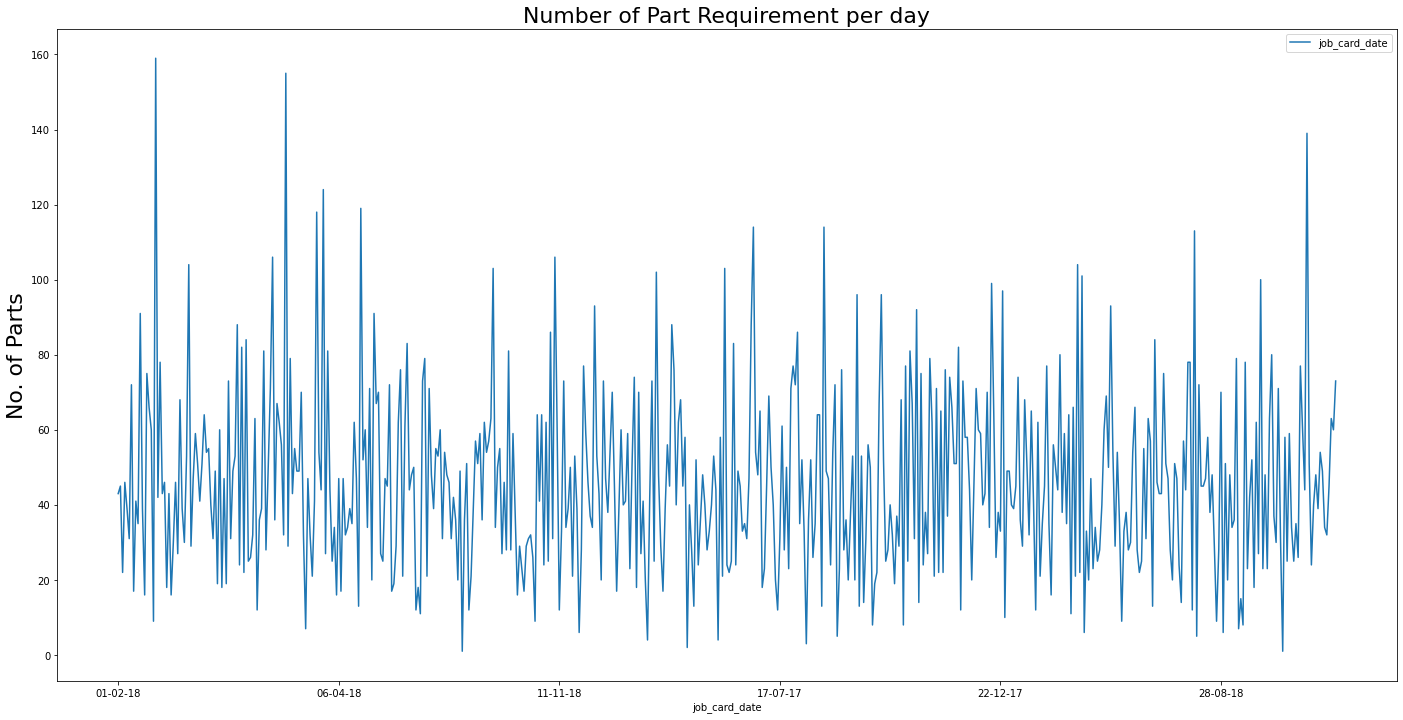

In [20]:
plt.rcParams['figure.figsize'] = (24,12)
data.groupby(['job_card_date'])['job_card_date'].count().to_frame().plot()
plt.title('Number of Part Requirement per day', fontdict={'fontsize':22})
plt.ylabel('No. of Parts', fontdict={'fontsize':22})

### Top Most Demanded Parts

C:\Users\LENOVO\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


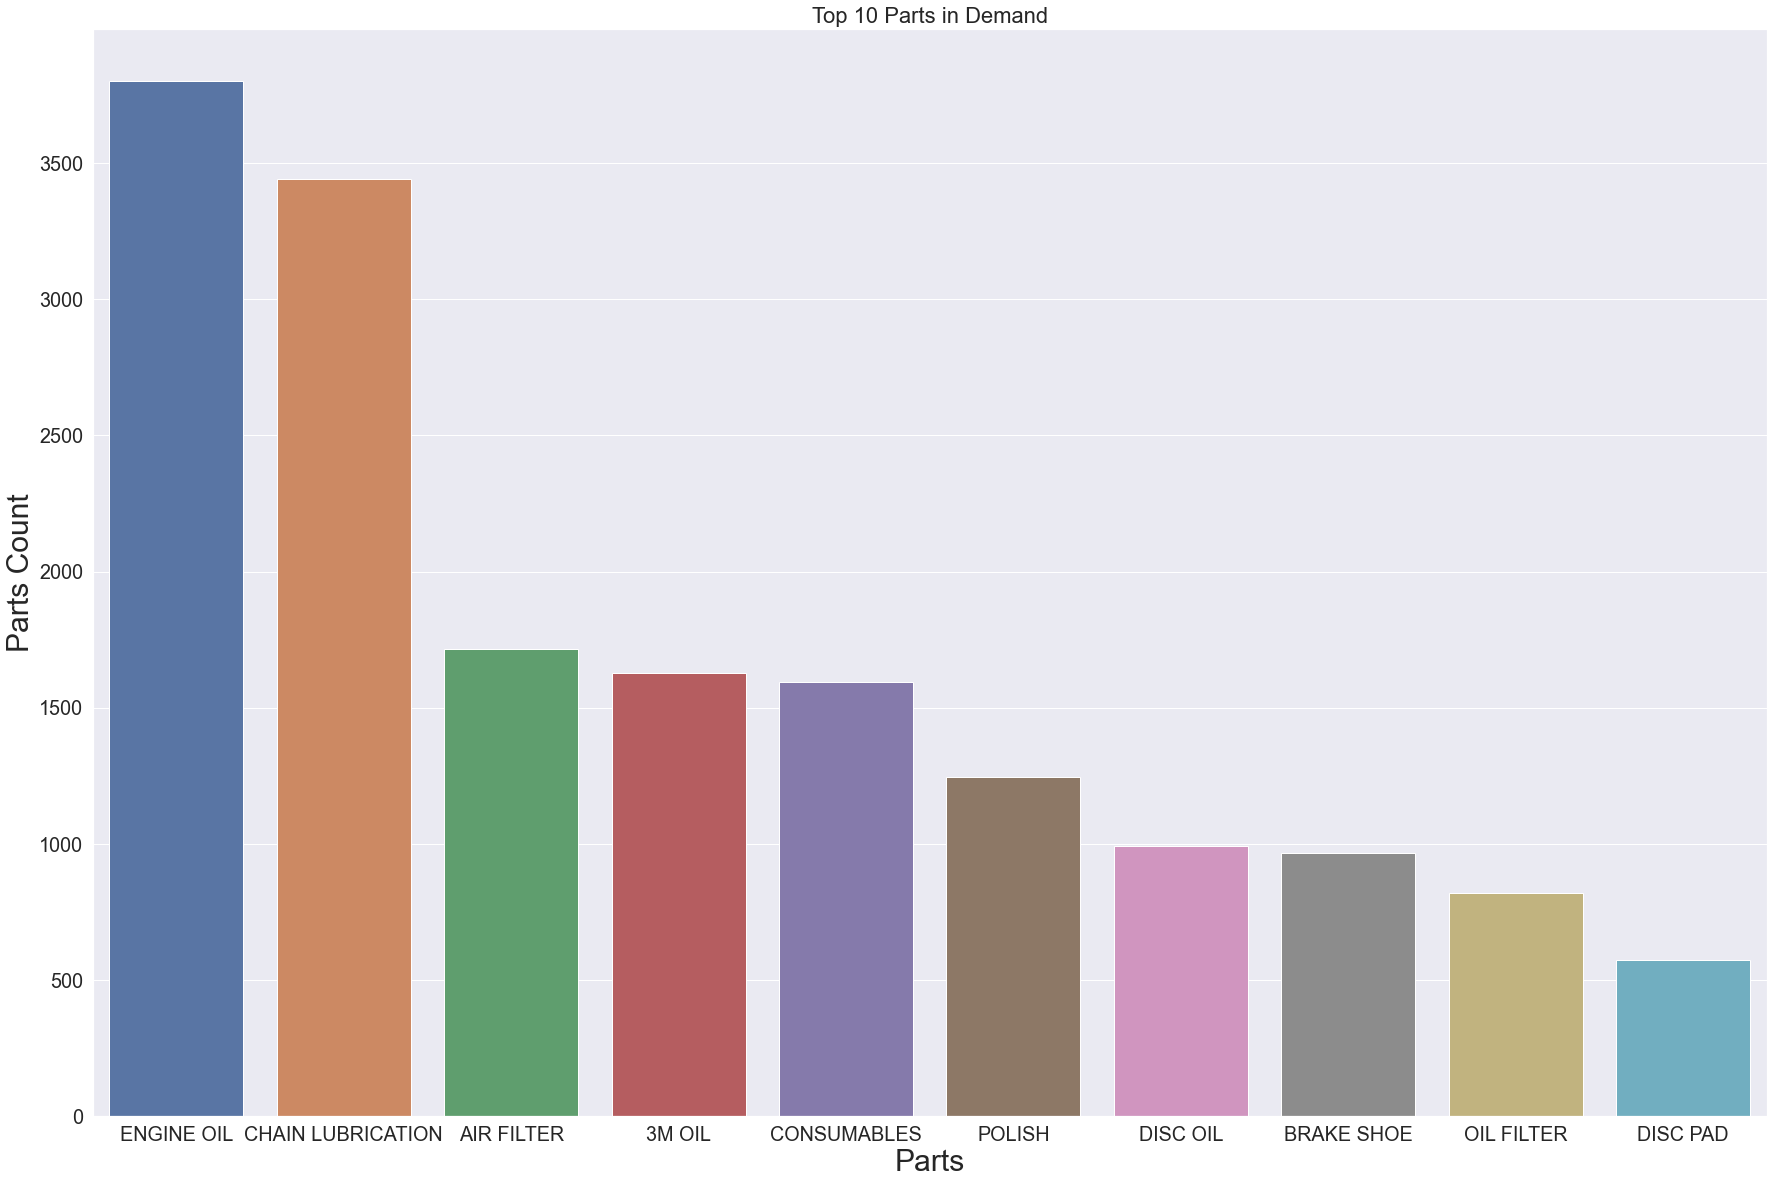

In [21]:
sns.set(style='darkgrid')
plt.figure(figsize=(30,20))
sns.set(font_scale=1.8)
sns.countplot(data['invoice_line_text'], order=data['invoice_line_text'].value_counts().index[:10])
plt.title('Top 10 Parts in Demand', fontdict={'fontsize':22});
plt.ylabel('Parts Count', fontdict={'fontsize':30});
plt.xlabel('Parts', fontdict={'fontsize':30});

### Observations -:

* Engine Oil is the most required Spare Part
* After Engine Oil, Chain Lubrication is second most required Spare Part followed by Air Filter

In [22]:
data.head(2)

,invoice_date,job_card_date,vehicle_model,current_km_reading,invoice_line_text
0,30-05-17,30-05-17,BAJAJ AVENGER STREET 220,50000,ENGINE OIL
1,02-06-17,31-05-17,BAJAJ PULSAR NS 200,758,ENGINE OIL


### Assumptions -:

* For Forecasting the only columns required are - 'job_card_date' & 'invoice_line_text'
* Let's rename the column with - 'Date' & 'Item'

In [23]:
inventory = data[['job_card_date', 'invoice_line_text']]

In [24]:
inventory.head()

,job_card_date,invoice_line_text
0,30-05-17,ENGINE OIL
1,31-05-17,ENGINE OIL
2,31-05-17,POLISH
3,31-05-17,CONSUMABLES
4,31-05-17,COOLANT OIL


In [25]:
inventory.columns

Index(['job_card_date', 'invoice_line_text'], dtype='object')

In [26]:
## Changing the names of columns

inventory = inventory.rename({'job_card_date' : 'Date', 'invoice_line_text' : 'Item'}, axis='columns')

In [27]:
pd.set_option('display.max_rows', None)

In [28]:
inventory.Item.value_counts()

ENGINE OIL                                        3802
CHAIN LUBRICATION                                 3441
AIR FILTER                                        1715
3M OIL                                            1628
CONSUMABLES                                       1595
POLISH                                            1245
DISC OIL                                           991
BRAKE SHOE                                         965
OIL FILTER                                         821
DISC PAD                                           575
WHEEL RUBBER                                       521
SPARK PLUG                                         421
CHAIN SPROCKET                                     396
SPROCKET RUBBER                                    347
SPROCKET BEARING                                   314
CHAIN OVERHAUL                                     284
CLUTCH CABLE                                       263
CLUTCH ASSEMBLY                                    212
CLUTCH COV

In [29]:
inventory.Item.value_counts().sum()

25333

In [30]:
inventory.Item.value_counts()[0:20]

ENGINE OIL             3802
CHAIN LUBRICATION      3441
AIR FILTER             1715
3M OIL                 1628
CONSUMABLES            1595
POLISH                 1245
DISC OIL                991
BRAKE SHOE              965
OIL FILTER              821
DISC PAD                575
WHEEL RUBBER            521
SPARK PLUG              421
CHAIN SPROCKET          396
SPROCKET RUBBER         347
SPROCKET BEARING        314
CHAIN OVERHAUL          284
CLUTCH CABLE            263
CLUTCH ASSEMBLY         212
CLUTCH COVER GASKET     190
TANK COVER              134
Name: Item, dtype: int64

In [31]:
(inventory.Item.value_counts()[0:20].sum())*100/inventory.Item.value_counts().sum()

78.39576836537323

### Observations -:

* There are total 25k orders in 21 Months.
* Top 20 Items make 19.8k orders in 21 Months.
* Top 20 Items make about 80% in 21 Months.

### Assumptions -:

* We do the Forecasting, for this top 20 Items.

In [32]:
inventory.shape

(25333, 2)

In [33]:
inventory['Item'] = inventory['Item'].astype('category')
inventory['Date'] = pd.to_datetime(inventory['Date'])

In [34]:
## Setting the Date as index

inventory.set_index('Date', inplace=True)

### Assumptions -:

* since, daily spare part demand is too low we will convert the data to weekly spare part demand.

In [35]:
inventory.shape

(25333, 1)

In [36]:
inventory.head()

,Item
Date,
2017-05-30,ENGINE OIL
2017-05-31,ENGINE OIL
2017-05-31,POLISH
2017-05-31,CONSUMABLES
2017-05-31,COOLANT OIL


In [37]:
counts = inventory['Item'].value_counts()
inventory = inventory[~inventory['Item'].isin(counts[counts < 131].index)]

In [38]:
Weekly_count = inventory['Item'].resample('W').count()

In [39]:
Weekly_count.size

126

In [40]:
126*7

882

In [41]:
pd.reset_option('display.max_rows', None)

Text(0, 0.5, 'No. of Parts')

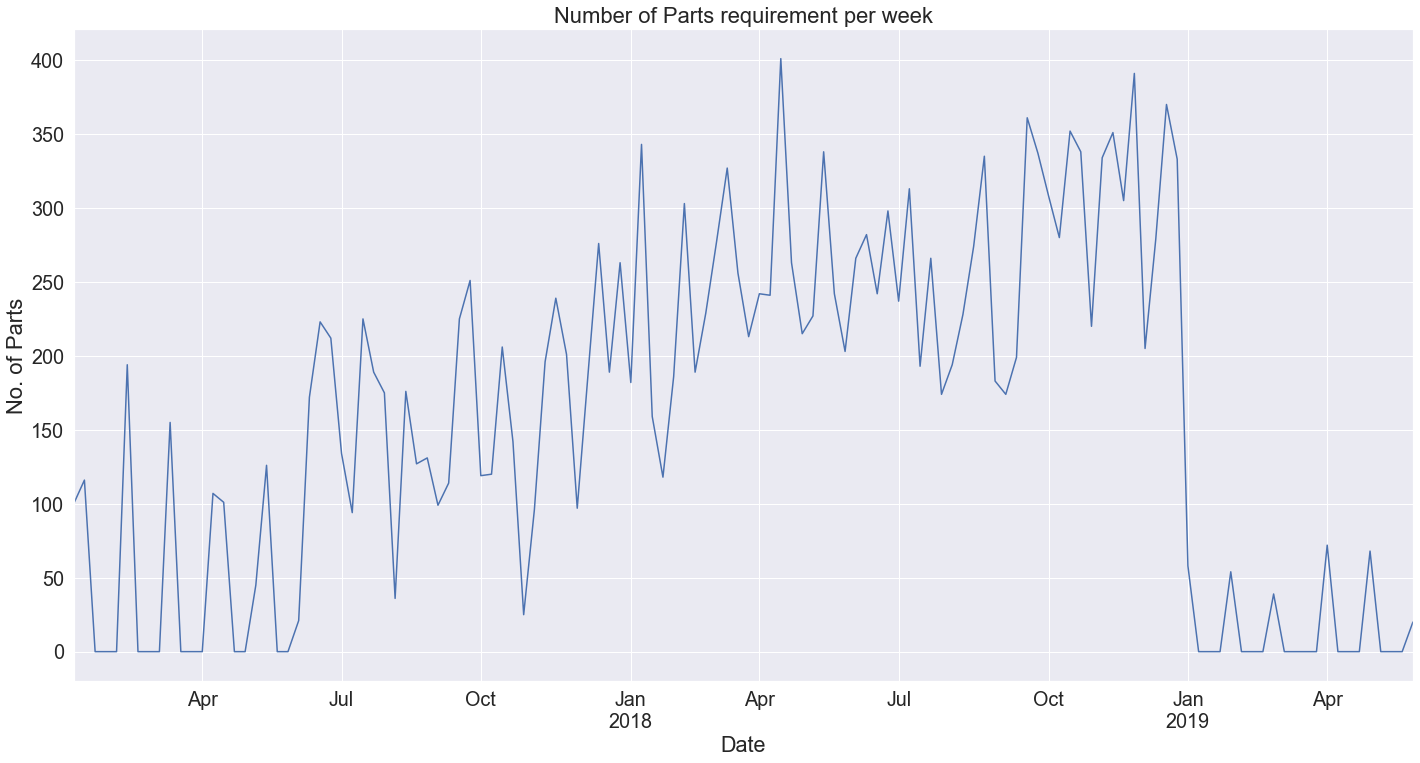

In [42]:
plt.rcParams['figure.figsize'] = (24,12)
Weekly_count.plot();
plt.title('Number of Parts requirement per week', fontdict = {'fontsize':22})
plt.ylabel('No. of Parts', fontdict = {'fontsize':22})

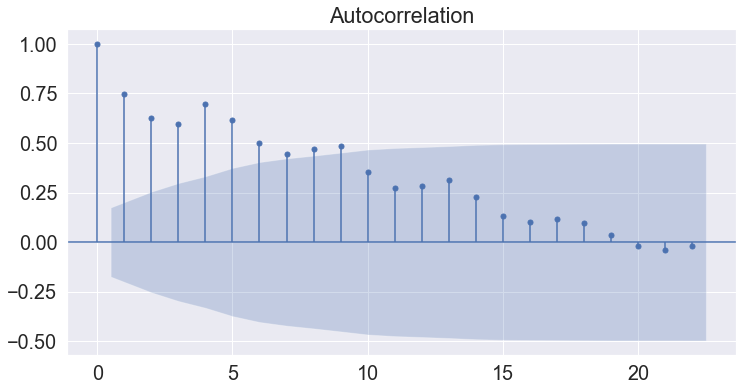

In [43]:
plt.rcParams['figure.figsize'] = (12,6)
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(Weekly_count);

### Observation -:

1. Data is not stationary.
2. Differencing of data is required, to make it stationary.

In [44]:
## Differencing the data, to make it stationary

Weekly_count_diff = Weekly_count.diff(periods=1)

Weekly_count_diff = Weekly_count_diff[1:]

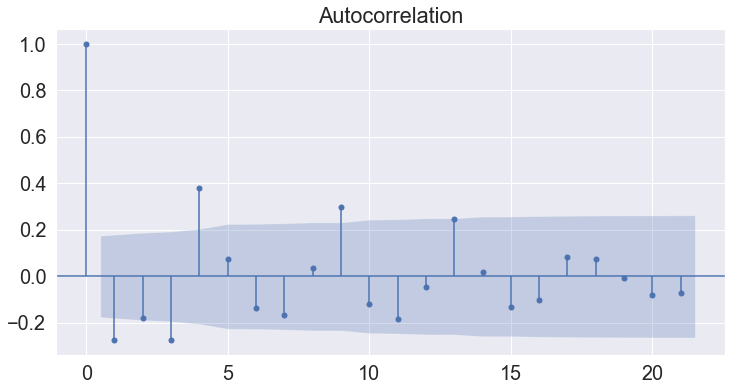

In [45]:
plot_acf(Weekly_count_diff);

In [46]:
X = Weekly_count_diff.values

train_data = X[:101]
test_data = X[101:]
prediction = []

In [47]:
print('train data length:', len(train_data))
print('test data length:', len(test_data))

train data length: 101
test data length: 24


In [48]:
from statsmodels.tsa.arima_model import ARIMA
model_arima = ARIMA(train_data, order=(3,1,1))
model_arima_fit = model_arima.fit()
print(model_arima_fit.aic)

C:\Users\LENOVO\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


1134.0727054108318


In [49]:
predictions = model_arima_fit.forecast(steps=24)[0]
predictions

array([ 13.238489  ,  64.09807204, -85.03871579,  13.50288652,
         6.61541986,  42.85879953, -33.11236204,  -2.75820872,
        -0.14434388,  25.62990338,  -9.40399153,  -3.86698765,
        -2.78025972,  13.88623267,  -0.2134909 ,  -1.54091313,
        -2.61737246,   6.98516122,   2.43657238,   0.45839257,
        -1.42864284,   3.45684931,   2.63514323,   1.47867909])

In [50]:
from sklearn.metrics import mean_squared_error

In [51]:
mean_squared_error(test_data, predictions)

3901.159693514839

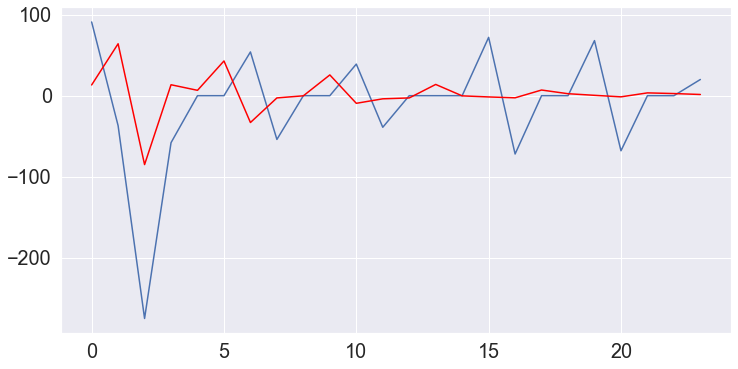

In [52]:
plt.plot(test_data)
plt.plot(predictions, color='red')

In [53]:
import itertools 
p=q=range(0,10)
d = range(2,6)
pdq = list(itertools.product(p,d,q))

In [54]:
import warnings
warnings.filterwarnings('ignore')
lowest_aic = 10000
for param in pdq:
    try:
        model_arima = ARIMA(traindata, order=param)
        model_arima_fit = model_arima.fit()
        if model_arima_fit.aic < lowest_aic:
            lowest_aic = model_arima_fit.aic
        print(param, model_arima_fit.aic, lowest_aic)
    except:
        continue

In [55]:
model_arima = ARIMA(train_data, order=(9,2,4))
model_arima_fit = model_arima.fit()

predictions = model_arima_fit.forecast(steps=24)[0]
predictions

array([-795.66000956, -364.83947364, -179.44508403,    3.97606489,
       -238.71619943, -178.86712599,   23.42033929, -135.04060763,
       -426.52248142, -505.24081513, -162.72222193, -237.22193241,
       -309.01870944, -404.53530445,  -88.17763556, -267.50746117,
       -415.99640077, -582.19682964, -298.49604424, -398.16608903,
       -481.87353885, -582.96338805, -341.91560738, -432.34155186])

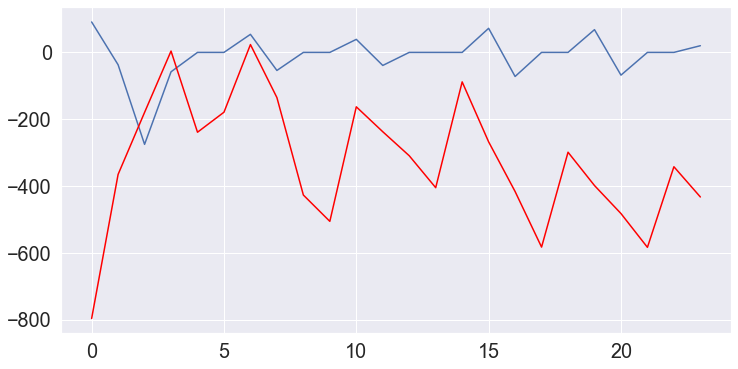

In [56]:
plt.plot(test_data)
plt.plot(predictions, color='red')